### DATES IMAGE CLASSIFIFCATION 

In [1]:
#importing important libraries 
# Imports
#not all used
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import img_to_array,  load_img
import matplotlib.pyplot as plt
from PIL import Image 
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
!unzip "/content/drive/MyDrive/dates.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dates/dates images/bumaan date/ca/125_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/126_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/127_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/128_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/129_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/12_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/130_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/131_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/132_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/133_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/134_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/135_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/136_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/137_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/138_ca.jpg  
  inflating: dates/dates images/bumaan date/ca/139

In [54]:
import pathlib
data_dir = pathlib.Path('/content/dates/dates images') # make a directory "data_dir"/content/drive/MyDrive/DatesImages/DatesImages
path = Path(data_dir)
path.ls() #list all the folders of dates images.
path

Path('/content/dates/dates images')

In [55]:
def number_of_images_in_dataset(dataset):
  images = list(dataset.glob("*/*/*.*"))
  return len(images)
print("number of all images in dataset: {}".format(number_of_images_in_dataset(data_dir)))

number of all images in dataset: 4998



# Visualization

In [56]:
# class_names=['Shishi date', 'bumaan date', 'fardh date', 'khalas date', 'lulu date']
num_class = 5

print( num_class)

5


In [57]:
import tensorflow as tf
batch_size = 128 #The batch size defines the number of samples that will be propagated through the network 
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  class_names=['Shishi date', 'bumaan date', 'fardh date', 'khalas date', 'lulu date'],
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  class_names=['Shishi date', 'bumaan date', 'fardh date', 'khalas date', 'lulu date'],
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



print("Label names:", class_names)
print("Image dimensions:", img_width, "x", img_height)
num_class = len(class_names)
print(" number of classes", num_class)
#You will use 80% of the images for training and 20% for validation.

Found 4998 files belonging to 5 classes.
Using 3999 files for training.
Found 4998 files belonging to 5 classes.
Using 999 files for validation.
Label names: ['Shishi date', 'bumaan date', 'fardh date', 'khalas date', 'lulu date']
Image dimensions: 256 x 256
 number of classes 5


In [58]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 256, 256, 3)
(128,)


Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [59]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [60]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [61]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [62]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomTranslation(height_factor=0.5, width_factor=0.5),
  layers.RandomZoom(0.4)
])


# TRAIN MODEL

### VGG19

In [63]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
pretrained_model=ResNet50(input_shape = (256, 256, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

# pretrained_model.summary()
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of resnet : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(5, activation='softmax') (x)       

model_rn = Model(pretrained_model.input, x) 


from tensorflow.keras.optimizers import RMSprop
model_rn.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])


last layer of resnet : output shape:  (None, 8, 8, 2048)


In [64]:
model_rn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

In [66]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 9e-1:
            self.model.stop_training = True

In [67]:
callback = CustomCallback()
history = model_rn.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[monitor],
  verbose=2,
  epochs =15
)


Epoch 1/15
32/32 - 173s - loss: 34.8531 - accuracy: 0.5931 - val_loss: 3.8516 - val_accuracy: 0.8248 - 173s/epoch - 5s/step
Epoch 2/15
32/32 - 20s - loss: 1.7304 - accuracy: 0.8690 - val_loss: 0.9001 - val_accuracy: 0.8689 - 20s/epoch - 636ms/step
Epoch 3/15
32/32 - 20s - loss: 0.2727 - accuracy: 0.9275 - val_loss: 0.4276 - val_accuracy: 0.8839 - 20s/epoch - 613ms/step
Epoch 4/15
32/32 - 19s - loss: 0.1301 - accuracy: 0.9535 - val_loss: 0.3865 - val_accuracy: 0.9039 - 19s/epoch - 599ms/step
Epoch 5/15
32/32 - 19s - loss: 0.0754 - accuracy: 0.9742 - val_loss: 0.4187 - val_accuracy: 0.8969 - 19s/epoch - 583ms/step
Epoch 6/15
32/32 - 19s - loss: 0.0634 - accuracy: 0.9792 - val_loss: 0.3759 - val_accuracy: 0.9149 - 19s/epoch - 603ms/step
Epoch 7/15
32/32 - 19s - loss: 0.0475 - accuracy: 0.9777 - val_loss: 0.3665 - val_accuracy: 0.9139 - 19s/epoch - 608ms/step
Epoch 8/15
32/32 - 19s - loss: 0.0410 - accuracy: 0.9852 - val_loss: 0.4008 - val_accuracy: 0.9149 - 19s/epoch - 588ms/step
Epoch 9/

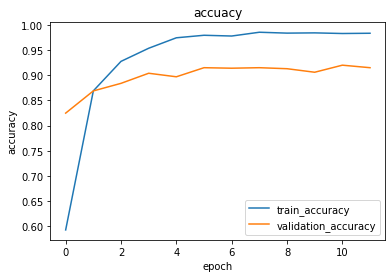

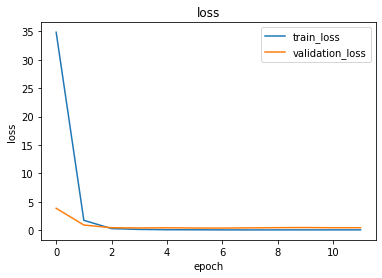

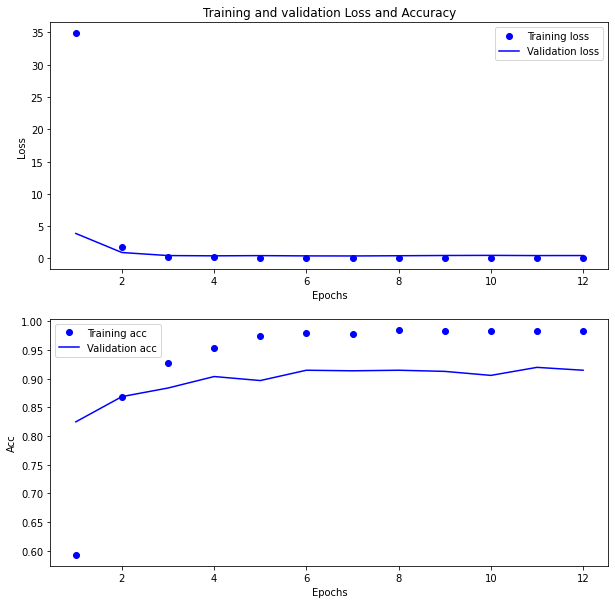

In [68]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()
plot_accuracy(history,'accuacy')
plot_loss(history, 'loss')

# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [69]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
y_prediction = model_rn.predict(val_ds)
y_prediction = np.argmax (y_prediction, axis = 1)
labels =  []
for x, y in val_ds:
  for i in y.numpy():
   labels.append(i)
from sklearn.metrics import classification_report
y_test = np.array(labels)
print(confusion_matrix(y_test, y_prediction ))
print(classification_report(y_test, y_prediction))

8/8 [==============================] - 4s 454ms/step
[[157   6  10   0   5]
 [  2 186   2   3   4]
 [ 14   5 175   1   5]
 [  2   2   3 202   0]
 [  6  10   4   2 193]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       178
           1       0.89      0.94      0.92       197
           2       0.90      0.88      0.89       200
           3       0.97      0.97      0.97       209
           4       0.93      0.90      0.91       215

    accuracy                           0.91       999
   macro avg       0.91      0.91      0.91       999
weighted avg       0.91      0.91      0.91       999



In [70]:
tf.keras.models.save_model(model_rn,'my_model3.hdf5')

# Evaluation

In [71]:
!pip install image-quality

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Quality and Categorization

1/1 [==============================] - 1s 867ms/step
This image most likely belongs to Shishi date with a 99.84 percent confidence and have a Image quality score of 77.33.


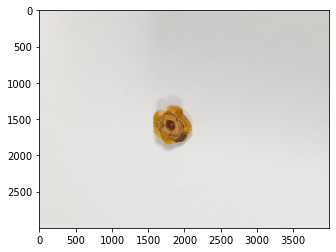

In [72]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/dates/dates images/Shishi date/ca/103_ca.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to bumaan date with a 100.00 percent confidence and have a Image quality score of 70.29.


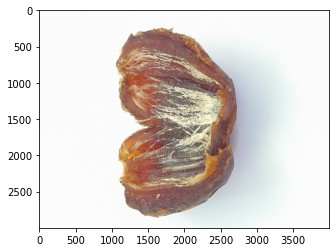

In [73]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/dates/dates images/bumaan date/o/110_o.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 26ms/step
This image most likely belongs to fardh date with a 98.99 percent confidence and have a Image quality score of 75.52.


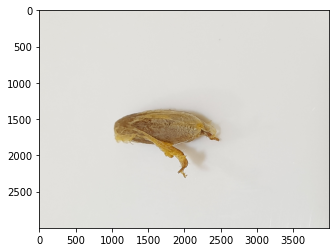

In [74]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/dates/dates images/fardh date/sf/108_sf.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to khalas date with a 100.00 percent confidence and have a Image quality score of 55.72.


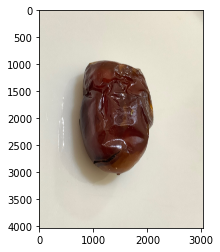

In [75]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/dates/dates images/khalas date/wh/104_wh.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to lulu date with a 100.00 percent confidence and have a Image quality score of 49.10.


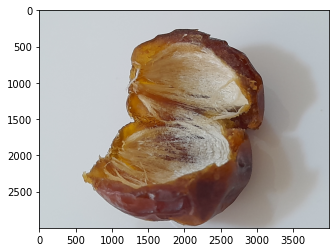

In [76]:
import imquality.brisque as brisque
import PIL.Image
image_path = "/content/dates/dates images/lulu date/o/105_o.jpg"
img = tf.keras.utils.load_img(
       image_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence and have a Image quality score of {:.2f}."
            .format(class_names[np.argmax(predictions)], 100 * np.max(predictions), brisque.score(PIL.Image.open(image_path)))
        )
# from google.colab.patches import cv2_imshow
# cv2_imshow(img_array1)

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(image_path)
imshow(testim)